### Load Data

conda activate preprocess_data

In [1]:
import glob
import sys
import os
import re
import numpy as np
import tifffile as tiff
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import random
from send2trash import send2trash

folder_path = r"C:\Users\durrlab-asong\OneDrive - Johns Hopkins\MUSE-BIT\MUSE_BIT_HE_Preprocessing_Code\20251119_MUSE-BIT_preprocessing_training_data"
sys.path.append(folder_path)
from processing_functions import *


## Compute Mean and STD of images and normalize first. 

In [7]:
root = r"C:\Users\durrlab-asong\Desktop\virtual_staining_training_data\duodenum\BIT"
train_crop_root = os.path.join(root, 'train', 'crypts', 'crop')
test_crop_root = os.path.join(root, 'test', 'crypts', 'crop')


compute_mean_std_and_save(train_crop_root, pattern='*.tif')

7
Saved mean and std to: C:\Users\durrlab-asong\Desktop\virtual_staining_training_data\duodenum\BIT\train\crypts\crop\image_stats.txt


## Break up BIT and MUSE images into training patches. 

### Load Data

In [27]:
import cv2

from virtual_staining_processing_inference_functions.processing_functions import flatfield_correct


def preprocess_training_flatfield_contrast_enhance_data(output_path, stack_path,clahe_clipLimit=2.0, clahe_tileGridSize=8):
    BIT_stacks = glob.glob(stack_path + r'\*.tif')
    save_path = os.path.join(output_path, 'preprocessed_flatfield_contrast_enhanced')
    os.makedirs(save_path, exist_ok=True)
    clahe = cv2.createCLAHE(clipLimit=clahe_clipLimit, tileGridSize=(clahe_tileGridSize, clahe_tileGridSize))
    for i, stack_name in enumerate(BIT_stacks):
        print(f"Processing stack {i+1} of {len(BIT_stacks)}")
        img_stack = tiff.imread(stack_name)
        img_stack = np.array(img_stack, dtype=img_stack.dtype)
        print(f"Original stack shape: {img_stack.shape}, dtype: {img_stack.dtype}")

        enhanced_stack = np.zeros(img_stack.shape, dtype=img_stack.dtype)



        for i, img in enumerate(img_stack):

            img = flatfield_correct(img, sigma=50)

            # Cast image to uint16 after normalization for CLAHE
            img_u16 = cv2.normalize(img, None, 0, 65535, cv2.NORM_MINMAX).astype(np.uint16)


            # Maybe use CLAHE for contrast enhancement
            #clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            enhanced_stack[i] = clahe.apply(img_u16)
            #enhanced_stack[i]  = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)

        # Save the enhanced stack
        base_name = os.path.basename(stack_name)
        save_path = os.path.join(save_path, f"enhanced_clahegrid={clahe_tileGridSize}_cliplimit={clahe_clipLimit}_{base_name}")
        tiff.imwrite(save_path, enhanced_stack)




In [28]:

preprocess_training_flatfield_contrast_enhance_data(test_crop_root, test_crop_root,clahe_clipLimit=3.0, clahe_tileGridSize=8)

Processing stack 1 of 1
Original stack shape: (32, 1302, 1866), dtype: uint16


In [ ]:



def compute_optimal_stride(img_shape, patch_size, overlap_percent=0.10):
    """
    Computes the optimal stride (x, y) for given image shape and patch size
    to achieve the desired overlap and ensure full coverage.

    Args:
        img_shape (tuple): (height, width) of the image
        patch_size (int): size of the square patch
        overlap_percent (float): desired fractional overlap (e.g., 0.1 for 10%)

    Returns:
        tuple: (x_stride, y_stride)
    """
    import math

    h, w = img_shape

    # Initial stride from overlap percentage
    stride = int(patch_size * (1 - overlap_percent))
    stride = max(1, stride)

    # Compute number of patches along height and width (round up to ensure coverage)
    n_patches_y = math.ceil((h - patch_size) / stride) + 1
    n_patches_x = math.ceil((w - patch_size) / stride) + 1

    # Recompute stride so that last patch ends exactly at (h - patch_size) and (w - patch_size)
    if n_patches_y > 1:
        y_stride = (h - patch_size) // (n_patches_y - 1)
    else:
        y_stride = 0

    if n_patches_x > 1:
        x_stride = (w - patch_size) // (n_patches_x - 1)
    else:
        x_stride = 0

    return y_stride, x_stride






def flatfield_correct(image, sigma=50):
    """
    Perform flat-field correction on an image using Gaussian smoothing.
    
    Parameters:
        image: np.ndarray
            Input image (grayscale or multi-channel).
        sigma: float
            Gaussian blur sigma for estimating the background illumination.
    
    Returns:
        corrected: np.ndarray
            Flat-field corrected image as float32.
    """
    image = np.ascontiguousarray(image, dtype=np.float32)
    #image = np.asarray(image).astype(np.float32) # ensure image is a numpy array. 
    blurred = cv2.GaussianBlur(image, ksize=(0, 0), sigmaX=sigma, sigmaY=sigma)
    corrected = image / (blurred + 1e-8)  # avoid division by zero
    return corrected

import numpy as np

def normalize_to_uint8_percentile(img: np.ndarray, percentile = 100) -> np.ndarray:
    """
    Normalize a grayscale image using min-max normalization with clipping at the 95th percentile,
    then scale to [0, 255] and convert to uint8.

    Parameters:
        img (np.ndarray): Input grayscale image (2D or 3D if single-channel).

    Returns:
        np.ndarray: Normalized image as uint8 in [0, 255].
    """
    img = img.astype(np.float32)
    p_min = np.min(img)
    p_max = np.percentile(img, percentile)

    img_clipped = np.clip(img, p_min, p_max)
    img_norm = (img_clipped - p_min) / (p_max - p_min + 1e-8)  # avoid divide-by-zero
    img_uint8 = (img_norm * 255).astype(np.uint8)

    return img_uint8

def break_image_into_training_patches_new(base_name, img_num, img, output_folder, patch_size,
                                      x_step_size, y_step_size):
    """
    Break an image into patches and save metadata for reconstruction. Supports custom x and y step sizes.

    Parameters:
        img_type (str): Identifier for the image type
        img_num (int or str): Image number
        img_path (str): Path to the input image
        img (PIL.Image or np.ndarray): Loaded image
        output_folder (str): Folder to save patches and metadata
        patch_size (int): Size of each square patch (patch is patch_size x patch_size)
        x_step_size (int): Horizontal stride between patches
        y_step_size (int): Vertical stride between patches
        n_random (int): Number of additional random patches to extract
        seed (int): Random seed for reproducibility
    """
    os.makedirs(output_folder, exist_ok=True)
    

    img_np = np.array(img)
    if img_np.ndim == 3 and img_np.shape[2] > 1:
        raise ValueError("This function currently only supports single-channel (grayscale) images.")
    
    h, w = img_np.shape[:2]
    patch_counter = 1
    patch_info_list = []
    taken_coords = set()
    name_no_ext = os.path.splitext(os.path.basename(base_name))[0]

    # Step 1: Regular grid patches
    for y in range(0, h - patch_size + 1, y_step_size):
        for x in range(0, w - patch_size + 1, x_step_size):
            patch = img_np[y:y+patch_size, x:x+patch_size]
            patch_name = f"{name_no_ext}_img={img_num}_P={patch_counter}.tif"
            patch_path = os.path.join(output_folder, patch_name)
            #patch = normalize_to_uint8_percentile(patch)
            Image.fromarray(patch).save(patch_path)
            patch_info_list.append(f"{patch_name},{x},{y},{patch_size},{patch_size}")
            taken_coords.add((x, y))
            patch_counter += 1
        

    # Step 3: Save metadata file
    metadata_file = os.path.join(output_folder, f"{name_no_ext}_patches_stitch_metadata.txt")
    with open(metadata_file, "w") as f:
        f.write(f"# Original image: {base_name}\n")
        f.write(f"# Original size: width={w}, height={h}\n")
        f.write(f"# Patch size: {patch_size}\n")
        f.write(f"# Step size: x={x_step_size}, y={y_step_size}\n")
        f.write(f"# Channels: 1\n")
        f.write("# Format: patch_filename,x,y,width,height\n")
        for info in patch_info_list:
            f.write(info + "\n")

    print(f"Saved {patch_counter-1} patches and metadata to {metadata_file}")



def process_training_data(output_path, BIT_stacks, patch_size_h, patch_size_w):
    for i, stack_name in enumerate(BIT_stacks):
        print(f"Processing stack {i+1} of {len(BIT_stacks)}")
        img_stack = tiff.imread(stack_name)
        img_stack = np.array(img_stack, dtype=img_stack.dtype)


        for i, img in enumerate(img_stack):

            img = flatfield_correct(img, sigma=50)


            #img = np.array(img, dtype=np.uint8)
  
            img_shape = img.shape
            #patch_size = (patch_size_h, patch_size_w)  # Example patch size
            stride_h, stride_w = compute_optimal_stride(img_shape, patch_size_w)

            print(f"Optimal Stride: {stride_h}x{stride_w}")

            break_image_into_training_patches_new(stack_name, i, img, output_path, patch_size_h,
                                      stride_w, stride_h)




6
C:\Users\durrlab-asong\Desktop\virtual_staining_training_data\duodenum\train\submucosa\crop\submucosa_Duodenum_IM0007_cropped_BIT_40X_frame17-68.tif
Processing stack 1 of 6
Optimal Stride: 395x451
Saved 12 patches and metadata to C:\Users\durrlab-asong\Desktop\virtual_staining_training_data\duodenum\train\submucosa\crop\patches\submucosa_Duodenum_IM0007_cropped_BIT_40X_frame17-68_patches_stitch_metadata.txt
Optimal Stride: 395x451
Saved 12 patches and metadata to C:\Users\durrlab-asong\Desktop\virtual_staining_training_data\duodenum\train\submucosa\crop\patches\submucosa_Duodenum_IM0007_cropped_BIT_40X_frame17-68_patches_stitch_metadata.txt
Optimal Stride: 395x451
Saved 12 patches and metadata to C:\Users\durrlab-asong\Desktop\virtual_staining_training_data\duodenum\train\submucosa\crop\patches\submucosa_Duodenum_IM0007_cropped_BIT_40X_frame17-68_patches_stitch_metadata.txt
Optimal Stride: 395x451
Saved 12 patches and metadata to C:\Users\durrlab-asong\Desktop\virtual_staining_traini

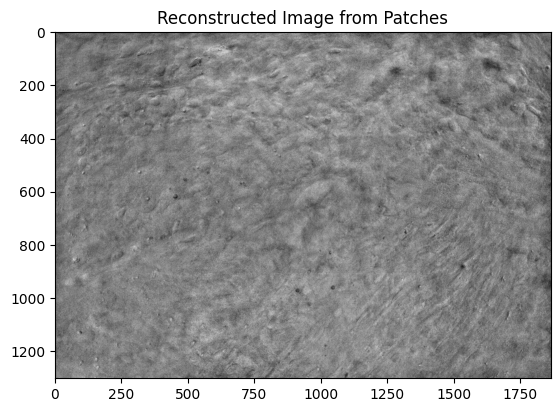

In [ ]:

root = r"C:\Users\durrlab-asong\Desktop\virtual_staining_training_data\duodenum"
train_root = os.path.join(root, 'train', 'submucosa', 'crop')
output_path_train = os.path.join(train_root, 'patches')
BIT_stacks = glob.glob(train_root + r'\*.tif')
print(len(BIT_stacks))
print(BIT_stacks[0])
process_training_data(output_path_train, BIT_stacks, 512, 512)


BIT_meta_data_stacks = glob.glob(output_path_train + r'\*.txt')
reconstructed_BIT_img = reconstruct_image_from_patches_preprocess(BIT_meta_data_stacks[0], output_path_train)
plt.imshow(reconstructed_BIT_img, cmap='gray')
plt.title("Reconstructed Image from Patches")       
plt.show()


In [4]:
root = r"C:\Users\durrlab-asong\Desktop\virtual_staining_training_data\duodenum"
test_root = os.path.join(root, 'test', 'random', 'crop')
test_BIT_stacks = glob.glob(test_root + r'\*.tif')
output_path_test = os.path.join(test_root, 'patches')
print(len(test_BIT_stacks))
print(test_BIT_stacks[0])

process_training_data(output_path_test, test_BIT_stacks, 512, 512)
BIT_meta_data_stacks = glob.glob(output_path_test + r'\*.txt')


reconstructed_BIT_img = reconstruct_image_from_patches(BIT_meta_data_stacks[0], output_path_test)
plt.imshow(reconstructed_BIT_img, cmap='gray')
plt.title("Reconstructed Image from Patches")       
plt.show()

31
C:\Users\durrlab-asong\Desktop\virtual_staining_training_data\duodenum\test\random\crop\crop_Duodenum_BIT_660nm_40X_IM0001.tif
Processing stack 1 of 31
Optimal Stride: 451x451
Saved 16 patches and metadata to C:\Users\durrlab-asong\Desktop\virtual_staining_training_data\duodenum\test\random\crop\patches\crop_Duodenum_BIT_660nm_40X_IM0001_patches_stitch_metadata.txt
Optimal Stride: 451x451
Saved 16 patches and metadata to C:\Users\durrlab-asong\Desktop\virtual_staining_training_data\duodenum\test\random\crop\patches\crop_Duodenum_BIT_660nm_40X_IM0001_patches_stitch_metadata.txt
Optimal Stride: 451x451
Saved 16 patches and metadata to C:\Users\durrlab-asong\Desktop\virtual_staining_training_data\duodenum\test\random\crop\patches\crop_Duodenum_BIT_660nm_40X_IM0001_patches_stitch_metadata.txt
Optimal Stride: 451x451
Saved 16 patches and metadata to C:\Users\durrlab-asong\Desktop\virtual_staining_training_data\duodenum\test\random\crop\patches\crop_Duodenum_BIT_660nm_40X_IM0001_patches_s

KeyboardInterrupt: 

### Get mean and std of all training patches

### Normalize patches by Mean and Std of all patches. 

In [ ]:
# Train
normalize_and_save_uint8_images(output_BIT_path_train, os.path.join(output_BIT_path_train, 'image_stats.txt'), os.path.join(output_BIT_path_train, 'normalized_BIT_train'), pattern='*.tif')
# Test

output_BIT_path_test = r"C:\Users\durrlab-asong\Desktop\virtual_staining_training_data\duodenum\test\crypts\crop\patches"
normalize_and_save_uint8_images(output_BIT_path_test, os.path.join(output_BIT_path_train, 'image_stats.txt'), os.path.join(output_BIT_path_test, 'normalized_BIT_test'), pattern='*.tif')


✅ Saved 2940 normalized images as uint8 TIFFs to: C:\Users\durrlab-asong\Desktop\virtual_staining_training_data\duodenum\train\crypts\crop\patches\normalized_BIT_train
✅ Saved 2940 normalized images as uint8 TIFFs to: C:\Users\durrlab-asong\Desktop\virtual_staining_training_data\duodenum\test\crypts\crop\patches\normalized_BIT_test


In [6]:
output_BIT_path_test = r"C:\Users\durrlab-asong\Desktop\virtual_staining_training_data\duodenum\test\crypts\crop\patches"
normalize_and_save_uint8_images(output_BIT_path_test, os.path.join(output_BIT_path_train, 'image_stats.txt'), os.path.join(output_BIT_path_test, 'normalized_BIT_test'), pattern='*.tif')


✅ Saved 384 normalized images as uint8 TIFFs to: C:\Users\durrlab-asong\Desktop\virtual_staining_training_data\duodenum\test\crypts\crop\patches\normalized_BIT_test
